The goal for this notebook is a streamlined, reproducable method of calculating the drift rates of all eligible planets in the NASA Exoplanet Database. 

There are 7 parameters necessary to calculate a planet's orbital drift rate: orbital period, semimajor axis, stellar mass, eccentricity, argument of periastron, inclination, and longitude of ascending node. As not all exoplanets have a measured value for each of these parameters, this notebook will provide methods to mitigate these insecurities.

In [ ]:
#general utility packages
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd
from scipy.stats import beta

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#remind matplotlib how to do 3D plotting
from mpl_toolkits.mplot3d import Axes3D

#cool package that makes good ellipses
!pip install PyAstronomy
import PyAstronomy
from PyAstronomy import pyasl

#frequently used constants
pi = np.pi
G_units = const.G
G = 6.67 * 10 **(-11)
c_units = const.c
c = 3 * 10**8

## Data from the NASA Exoplanet Archive

The data I will be using for this project comes from the NASA Exoplanet Archive (NEA) which produces a nice spreadsheet. The column names I will be frequently using are:

Stellar Mass = st_mass

Planet Name = pl_name

Semimajor Axis = pl_orbsmax

Period in Days = pl_orbper

Eccentricity = pl_orbeccen

Inclination = pl_orbincl

Argument of Periapse = pl_orblper

Discovery Method = discoverymethod

Discovery Facility = disc_facility

In [ ]:
#Downloade csv from NEA, currently at 4424 confirmed planets (7/10/21)
df_all = pd.read_csv('/Users/megan/Downloads/orbital_parameters_all.csv')

## Applying Kepler's Third Law

Kepler's Third Law relates 3 of our necessary parameters to each other: stellar mass, semimajor axis, and orbital period. Thus, calculations can be run on any planet with 2/3 of these parameters measured to get the third one. In this step, that is what I will do. 

Planets that only have 1 out of these 3 cannot be used in this project. All three of these parameters are not presumed to be nicely distributed across some bound numbers (like other parameters are,) so I have no current methods of simulating these values. As of 7/10/21, this is only 30 planets out of 4424 planets, so I am counting this as a negligible loss to our sample. This section of the code also saves the planets that are not eligible to a text file.

In [ ]:
def keplers_third_law(df):
    trashed_planets = []
    df_solved = df
    for index, row in df_solved.iterrows():
        if pd.isna(row['pl_orbsmax']) == False and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
        #All 3 values have numbers, don't need to be solved or dropped
            pass
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row  
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #3/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
            #only semimajor axis is missing
            df.loc[index, 'pl_orbsmax'] = (6.67*10**(-11) * row['st_mass'] * row['pl_orbper']**2 /(4*pi**2)) **(1/3)
            #Kepler's Third Law solved for semimajor axis
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['pl_orbsmax']) == False and pd.isna(row['st_mass']) == False:
            df.loc[index, 'pl_orbper'] = (4 * pi**2 * row['pl_orbsmax']**3/(6.67*10**(-11) * row['st_mass']))**(1/2)
            #Kepler's Third Law solved for period
        else:
            df.loc[index, 'st_mass'] = 4*pi**2*row['pl_orbsmax']**3/(6.67*10**(-11)*row['pl_orbper']**2)
            #Kepler's Third Law solved for stellar mass
    with open("trashed_planets.txt", "w") as file:
        file.write(str(trashed_planets))
        #saving the trashed planets to an external file
    return df_solved

In [ ]:
df_kepler_solved = keplers_third_law(df_all)

## Randomly Assigned Values: Inclination, Argument of Periastron, and Longitude of Ascending Node

An orbit's inclination, argument of periastron, and longitude of ascending node essentially have no rhyme or reason to be distributed a certain way, so I will simulate missing values for these angles to be random across all possible values. That is, from 0 to 360 degrees for argument of periastron and longitude of ascending node, and from -90 to 90 degrees for inclination.

In [ ]:
def assign_inclination(df):
    df_inc = df
    for index, row in df_inc.iterrows():
        random_inc = random.uniform(-90, 90)
        if pd.isna(row['pl_orbincl']) == True:
        #If the inclination is null    
            df.loc[index, 'pl_orbincl'] = random_inc
    return df_inc

In [ ]:
df_kepler_inc = assign_inclination(df_kepler_solved)

In [ ]:
def assign_arg_of_peri(df):
    df_aop = df
    for index, row in df_aop.iterrows():
        random_aop = random.uniform(0, 360)
        if pd.isna(row['pl_orblper']) == True:
        #If the argument of periastron is null    
            df.loc[index, 'pl_orblper'] = random_aop
    return df_aop

In [ ]:
df_kepler_inc_aop = assign_arg_of_peri(df_kepler_inc)

In [ ]:
#There are basically no measured longitudes of ascending node (only 4/4424, so I'll just randomly assign all of them)
def assign_long_of_asc_node(df):
    df_loan = df
    loans = []
    for index in df_loan.iterrows():
        random_loan = random.uniform(0, 360)
        loans.append(random_loan)
    df_loan['long_of_asc_node'] = loans
    return df_loan

In [ ]:
df_kepler_inc_aop_loan = assign_long_of_asc_node(df_kepler_inc_aop)

## Eccentricity : Beta Distribution

For unmeasured eccentricities, I will be pulling numbers from a beta distribution as described in Kipping 2013.

In [ ]:
def assign_ecc(df):
    df_ecc = df
    for index, row in df_ecc.iterrows():
        random_ecc = beta.rvs(0.867, 3.03)
        if pd.isna(row['pl_orbeccen']) == True:
        #If the eccentricity is null    
            df.loc[index, 'pl_orbeccen'] = random_ecc
    return df_ecc

In [ ]:
df_all = assign_ecc(df_kepler_inc_aop_loan)
df_all.to_csv('all_orbital_parameters.csv')
#Our dataframe is complete, so I am saving it to a csv to avoid having multiple versions running around 
#as many of the values would change each time the code is run

## Calculating Drift Rates
Parameters should be in units of au, years, and degrees: 

e is the eccentricity of the orbit


omega is longitude of ascending node in degrees


i is inclination in degrees


w is argument is periapse in degrees


num_timestep is the number of data points to build the ellipse, I've been using 200

In [184]:
def drift_rates(semimajor, period, e, omega, i, w, stellar_mass, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    radius = ke.radius(t)
    total_acc = G*stellar_mass*u.Msun/(radius* u.au)**2
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, num_timestep):
        position_vector = ke.xyzPos(t)[i,:]
        radius = ke.radius(t)
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * total_acc[i].si).value/c)
    return z_acceleration_array

In [276]:
drift_rates_df = pd.DataFrame()
cumulative_drift_rates = []
for index, row in df.iterrows():
    drift_rates_list = drift_rates(row['pl_orbsmax'], row['pl_orbper']/365.25, row['pl_orbeccen'], row['long_of_asc_node'], row['pl_orbincl'], row['pl_orblper'], row['st_mass'], 200)
    drift_rates_df[row['pl_name']] = drift_rates_list
    for drift_rate in drift_rates_list:
        #This list is for plotting histograms in one color
        cumulative_drift_rates.append(drift_rate)
drift_rates_df.to_csv('drift_rates.csv')

In [262]:
drift_rates_df = pd.read_csv('drift_rates.csv')
#The data frame can be sorted for color coding histograms later

## Plotting Tools

To visualize my drift rates, I will plot a series of varying histograms highlighting various aspects of the data. In this section, I will describe some tools I will use to enhance the plots.

In [ ]:
def percentage_of_central_values(percent, list_):
    #This function will provide bounds on the histogram for an any percent of the values
    sorted_list = sorted(map(abs, list_))
    number_of_entries = round(len(list_) * percent/100)
    central_values = sorted_list[0:number_of_entries]
    return central_values

In [197]:
def sort_by_disc_method(df):
    #I will use this function to create separate the planets by discovery method into a dictionary
    methods = df['discoverymethod'].value_counts()[:8].index.tolist()
    method_planets = {}
    for method in methods:
        lst = []
        for index, row in df.iterrows():
            if row['discoverymethod'] == method:
                lst.append(row['pl_name'])
        method_planets.update({method: lst})
    w = csv.writer(open("method_planets.csv", "w"))
    for key, val in method_planets.items():
        w.writerow([key, val])
    return method_planets

In [198]:
sorted_by_disc_method = sort_by_disc_method(df)

In [247]:
def cat_drift_rates(dct, df):
    #This function will take categorized planets and return their drift rates in a nested list for plotting
    drift_rates = []
    for key in dct.keys():
        lst = []
        for val in dct[key]:
            for col in df:
                if col == val:
                    for row in df[col]:
                        lst.append(row)
        drift_rates.append(lst)
    return drift_rates

In [248]:
sorted_by_disc_method_dr = cat_drift_rates(sort_by_disc_method(df), drift_rates_df)

## Plots

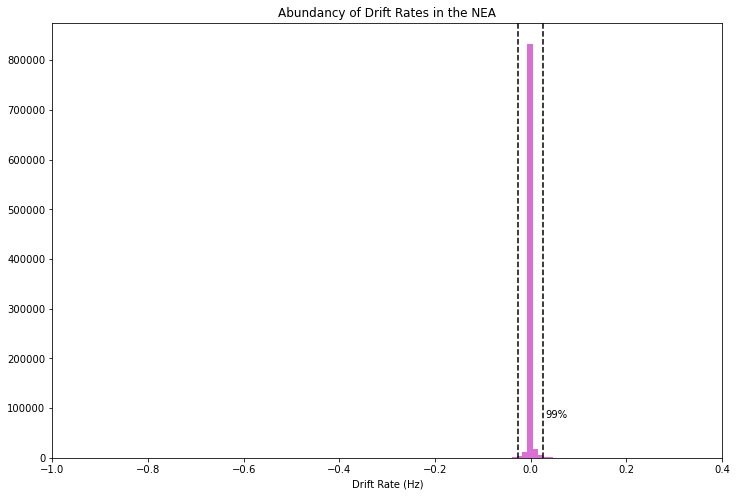

In [279]:
#Linearly Scaled Histogram with Central 50%
plt.figure(figsize = [12,8])
linear_markers = percentage_of_central_values(99, cumulative_drift_rates)
limit_linear = linear_markers[-1]
plt.hist(cumulative_drift_rates, color = 'orchid', bins = 100)
plt.axvline(x = limit_linear, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_linear, color = 'k', linestyle = 'dashed')
plt.text(1.2*limit_linear, 8*10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.xlim(-1, 0.4)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('linear_histogram.png')
plt.show()

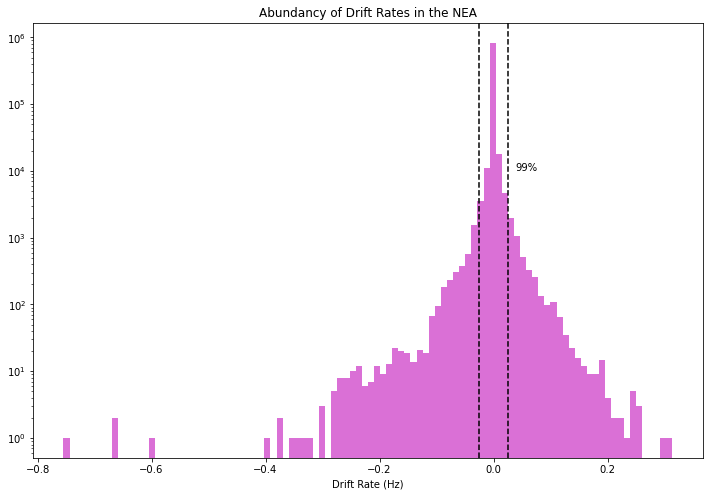

In [278]:
#Logarithmically Scaled Histogram with Central 99%
plt.figure(figsize = [12,8])
log_markers = percentage_of_central_values(99, cumulative_drift_rates)
limit_log = log_markers[-1]
plt.hist(cumulative_drift_rates, color = 'orchid', bins = 100)
plt.axvline(x = limit_log, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_log, color = 'k', linestyle = 'dashed')
plt.text(1.5*limit_log, 10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.savefig('log_histogram.png')
plt.title('Abundancy of Drift Rates in the NEA')
plt.show()

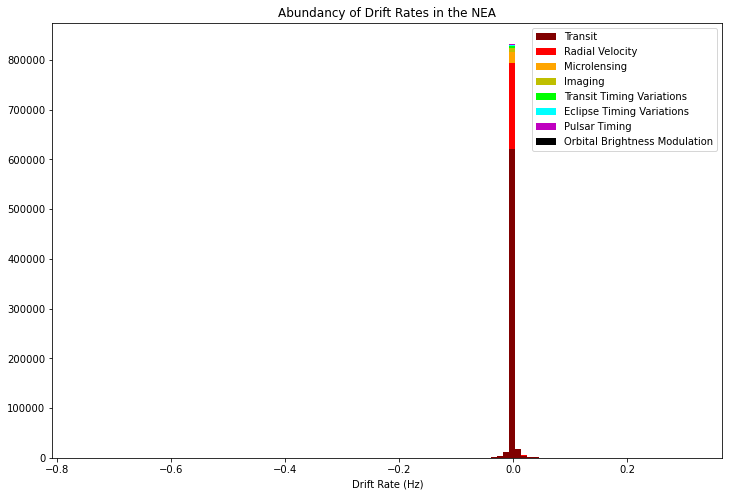

In [254]:
#Linearly Scaled Histogram by Discovery Method
plt.figure(figsize = [12,8])
labels = df['discoverymethod'].value_counts()[:8].index.tolist()
plt.hist(sorted_by_disc_method_dr, bins = 1000, color = ['maroon', 'red','orange', 'y', 'lime', 'cyan', 'm', 'k'],  stacked = True)
plt.xlabel('Drift Rate (Hz)')
plt.yscale('linear')
plt.legend(labels)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('linear_disc_method_histogram.png')
plt.show()